# Image Classification with Convolutional Neural Networks

In [38]:
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

from nimrod.utils import set_seed
from nimrod.image.datasets import ImageDataModule

from matplotlib import pyplot as plt
from hydra.utils import instantiate
from omegaconf import OmegaConf
from rich import print
from typing import Callable, Optional

from functools import partial
import wandb

%load_ext autoreload
%autoreload 2
set_seed()


Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Module

In [2]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
print(OmegaConf.to_yaml(cfg))

_target_: nimrod.image.datasets.ImageDataModule
name: mnist
data_dir: ../data/image
train_val_split:
- 0.8
- 0.2
batch_size: 64
num_workers: 0
pin_memory: true
persistent_workers: false
transforms:
  _target_: torchvision.transforms.Compose
  transforms:
  - _target_: torchvision.transforms.ToTensor
  - _target_: torchvision.transforms.Normalize
    mean:
    - 0.1307
    std:
    - 0.3081

In [3]:
cfg.data_dir = "../data/image"
cfg.batch_size = 128
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

Seed set to 42
[19:22:22] INFO - Init ImageDataModule for mnist
[19:22:27] INFO - loading dataset mnist with args () from split train
[19:22:35] INFO - loading dataset mnist with args () from split test
[19:22:38] INFO - split train into train/val [0.8, 0.2]
[19:22:38] INFO - train: 48000 val: 12000, test: 10000


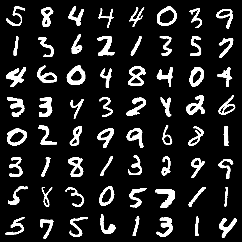

In [4]:
xb, yb = next(iter(dm.train_dataloader()))
dm.show_batch(xb[:64])

## Model

In [59]:
cfg_model = OmegaConf.load('../config/model/image/convnetx.yaml')
cfg_model.nnet.n_features = [1, 8, 16, 32, 16]
print(OmegaConf.to_yaml(cfg_model))

Seed set to 42
Seed set to 42


_target_: nimrod.models.conv.ConvNetX
_partial_: true
num_classes: 10
nnet:
  _target_: nimrod.models.conv.ConvNet
  n_features:
  - 1
  - 8
  - 16
  - 32
  - 16
  num_classes: ${..num_classes}
  kernel_size: 3
  bias: null
  normalization:
    _target_: hydra.utils.get_class
    path: torch.nn.BatchNorm2d
  activation:
    _target_: hydra.utils.get_class
    path: torch.nn.ReLU

In [6]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
nnet = instantiate(cfg_model.nnet)
nnet(X).shape

Seed set to 42


torch.Size([64, 10])

## Optimizer

In [7]:
cfg_sched = OmegaConf.load('../config/scheduler/one_cycle_lr.yaml')
scheduler = instantiate(cfg_sched)
print(OmegaConf.to_yaml(cfg_sched))

_target_: torch.optim.lr_scheduler.OneCycleLR
_partial_: true
max_lr: 0.01
total_steps: null
pct_start: 0.3
anneal_strategy: cos
div_factor: 10
three_phase: false

In [8]:
cfg = OmegaConf.load('../config/optimizer/adam_w.yaml')
optimizer = instantiate(cfg)
print(OmegaConf.to_yaml(cfg))

_target_: torch.optim.AdamW
_partial_: true
lr: 0.0001
weight_decay: 1.0e-05

## Training

In [9]:
cfg = OmegaConf.load('../config/callbacks/learning_rate_monitor.yaml')
lr_monitor = instantiate(cfg.learning_rate_monitor)
print(type(lr_monitor))
print(OmegaConf.to_yaml(cfg))

<class 'lightning.pytorch.callbacks.lr_monitor.LearningRateMonitor'>

learning_rate_monitor:
  _target_: lightning.pytorch.callbacks.LearningRateMonitor
  logging_interval: step

## LR Finder

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[23:02:33] INFO - ConvNetX: init
[23:02:33] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
[23:02:37] INFO - loading dataset mnist with args () from split train
[23:02:44] INFO - loading dataset mnist with args () from split test
[23:02:47] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[23:02:47] WARNING - no scheduler has been setup
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-pack

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.009999999999999997
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_f61f63de-7f68-4fb0-8874-352e7be7623e.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/tutorials/.lr_find_f61f63de-7f68-4fb0-8874-352e7be7623e.ckpt


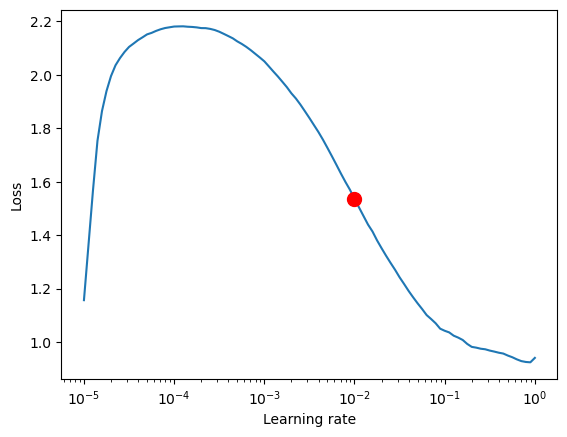

Suggested learning rate: 0.009999999999999997

In [47]:
# LR_FINDER

def find_lr(
    model: Callable[...,torch.nn.Module], #partial
    datamodule: ImageDataModule,
    num_training:int=100,
    plot:bool=True
    ):

    trainer = Trainer(accelerator="auto")
    tuner = Tuner(trainer)
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=1e-5)
    model = model(optimizer=optimizer, scheduler=None)
    lr_finder = tuner.lr_find(
        model,
        datamodule=datamodule,
        min_lr=1e-5,
        max_lr=1.0,
        num_training=num_training,  # number of iterations
        # attr_name="optimizer.lr",
    )
    
    if plot:
        fig = lr_finder.plot(suggest=True)
        plt.show()
    return lr_finder.suggestion()


N_EPOCHS = 5
# cfg_model.nnet.n_features = [1, 8, 16, 32, 16]
cfg_model.nnet.n_features = [1, 16, 32, 64, 32]
model = instantiate(cfg_model) #partial
suggested_lr = find_lr(model, dm, plot=True)
print(f"Suggested learning rate: {suggested_lr}")




## one cycle train

In [83]:
# ONE-CYCLE TRAIN

def one_cycle_train(
    model: Callable[...,torch.nn.Module], #partial
    datamodule: ImageDataModule,
    max_lr:float=0.1,
    n_epochs: int=5,
    project_name:str='MNIST-Classifier',
    tags = ['arch', 'dev'],
    test:bool=True
    ):

    model_name = model.func.__name__    

    wandb_logger = WandbLogger(
        project=project_name,
        name=f"{model_name}-bs:{dm.batch_size}-epochs:{n_epochs}",
        save_dir='wandb',
        entity='slegroux',
        tags=tags,
        group=model_name,
        log_model=True
        )

    lr_monitor = LearningRateMonitor(logging_interval="step")

    trainer = Trainer(
        accelerator="auto",
        max_epochs=n_epochs,
        logger=wandb_logger,
        callbacks = [lr_monitor],
        check_val_every_n_epoch=1,
        log_every_n_steps=1
        )

    total_steps = len(dm.train_dataloader()) * n_epochs
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=1e-5)
    scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, total_steps=total_steps, max_lr=max_lr) 
    model = model(optimizer=optimizer, scheduler=scheduler)
    
    trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())
    if test:
        trainer.test(model, dm.test_dataloader())
    wandb.finish()


Seed set to 42
[autoreload of nimrod.models.conv failed: Traceback (most recent call last):
  File "/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


In [46]:

N_EPOCHS = 5

# feats_dim = [1, 8, 16, 32, 16]
feats_dim = [1, 16, 32, 64, 32]
cfg_model.nnet.n_features = feats_dim
model = instantiate(cfg_model) # partial instantiation
print(model.func.__name__)


# one_cycle_train(
#     model,
#     dm,
#     n_epochs=N_EPOCHS,
#     max_lr=suggested_lr,
#     project_name='MNIST-Classifier',
#     tags=[f"feats:{feats_dim}", 'dev'])

ConvNetX

## Experiments

In [60]:
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 256
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[11:47:45] INFO - Init ImageDataModule for mnist
[11:47:53] INFO - loading dataset mnist with args () from split train
[11:48:08] INFO - loading dataset mnist with args () from split test
[11:48:16] INFO - split train into train/val [0.8, 0.2]
[11:48:16] INFO - train: 48000 val: 12000, test: 10000


In [87]:
# SETUP
N_EPOCHS = 1
cfg_model = OmegaConf.load('../config/model/image/convnetx.yaml')
# feats_dim = [1, 8, 16, 32, 16]
feats_dim = [1, 4, 8, 16, 8]
# feats_dim = [1, 16, 32, 64, 32]
cfg_model.nnet.n_features = feats_dim
model = instantiate(cfg_model) #partial

# LR Finder
# suggested_lr = find_lr(model, dm, plot=True)
# print(f"Suggested learning rate: {suggested_lr}")
suggested_lr = 1e-2

# ONE-CYCLE TRAINING
one_cycle_train(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name='MNIST-Classifier',
    tags=[f"feats:{feats_dim}", 'dev'])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[13:16:03] INFO - ConvNetX: init
[13:16:03] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


[13:16:04] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[13:16:04] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | ConvNet            | 3.4 K  | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | train
8 | val_acc_best | MaxMetric          | 0      | train
------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW,▁▁▂▃▃▅▆▆▆▇████████▇▇▇▇▇▇▇▆▆▆▅▄▃▃▃▂▂▂▁▁▁▁
train/acc_epoch,▁
train/acc_step,▁▃▄▅▄▅▅▆▅▇▇▇▇███▇███████████████████████
train/loss_epoch,▁
train/loss_step,██▇▇▇▇▆▆▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇█████
val/acc,▁
val/acc_best,▁
val/loss,▁
epoch,0
